### Face Detection with Mediapipe + Face Swapping with Homography ###

In [90]:
# ref: https://www.youtube.com/watch?v=V9bzew8A1tc&ab_channel=Murtaza%27sWorkshop-RoboticsandAI
# ref map: https://github.com/tensorflow/tfjs-models/blob/master/facemesh/mesh_map.jpg

In [91]:
import numpy as np
import time
import cv2
import mediapipe as mp

In [92]:
import sys
sys.path.append('C:/Users/Mafeus/Desktop/Git_Repos/OpenCV')
import OpCV_Utils

In [106]:
# Creating Objects Instances:
mpDraw = mp.solutions.drawing_utils
mpFaceMesh = mp.solutions.face_mesh
faceMesh = mpFaceMesh.FaceMesh(static_image_mode=False, max_num_faces=5,
                                min_detection_confidence=0.3, min_tracking_confidence=0.3)

drawSpec = mpDraw.DrawingSpec(thickness=1, circle_radius=1)

In [107]:
# Some Region Landmarks Locations:
leftEye = [7, 33, 246, 161, 160, 159, 158, 173, 163, 144, 145, 153, 154, 155, 133, 240]
rightEye = [249, 263, 362, 373, 374, 380, 382, 384, 385, 386, 387, 388, 368, 390, 463, 468]
mouthLine = [179, 86, 15, 315, 403]
noseLine = [168, 6, 197, 195, 5, 4, 1, 19, 34, 370, 462, 250, 141, 242, 20, 219, 235, 240, 439, 455, 460]

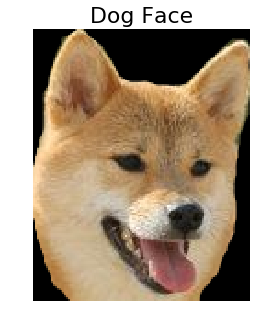

In [111]:
# Face to Swap:
dog_img = cv2.imread('dog_head.png')
OpCV_Utils.show_single_img_plt(cv2.cvtColor(dog_img.copy(), cv2.COLOR_BGR2RGB), 'Dog Face', fig_size = (5,5))

In [114]:
# Load Video:
video = 'C:/Users/Mafeus/Desktop/Git_Repos/OpenCV/Testing Grounds/ztest_media/people.mp4'
cap = cv2.VideoCapture(video)
video_fps = cap.get(cv2.CAP_PROP_FPS)

while True:
        
    start = time.time()
    
    success, frame = cap.read()
    
    if not success:
        print('Server OFF')
        break
        
    frame = cv2.resize(frame, (600,500))
    
    ###############################################################################################################
    
    frameRGB = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2RGB)
    results = faceMesh.process(frameRGB)
    
    blank_image = np.zeros_like(frame)
    
    if results.multi_face_landmarks:
        for faceLandmarks in results.multi_face_landmarks:
            #mpDraw.draw_landmarks(frame, faceLandmarks, mpFaceMesh.FACE_CONNECTIONS, drawSpec, drawSpec)
            
            landmark_coords = []
            xnose = 0
                        
            # Get each landmark location and id:
            for id, landmark in enumerate(faceLandmarks.landmark):
                h, w, c = frame.shape
                x, y = int(landmark.x*w), int(landmark.y*h)
                
                if (id == 365) or (id == 136) or (id == 103) or (id == 332):
                        landmark_coords.append([[x, y]])
                        
                if (id == 1):
                    xnose = x
                    
                if (id == 141):
                    xnoseline = x
                    
            dog_head = dog_img.copy()
            
            if (xnoseline  > xnose):
                 dog_head = cv2.flip(dog_head, 1)
                
            dog_head = cv2.resize(dog_head, (frame.shape[1], frame.shape[0]))
            face_points = np.array(landmark_coords)
                   
            img_points = np.array([[[0, 0]], [[dog_head.shape[1], 0]], 
                                [[0, dog_head.shape[0]]], [[dog_head.shape[1], dog_head.shape[0]]]])
            
            face_points = OpCV_Utils.reorder4points(face_points)
             
            expand_polygon = np.array([[[-20, -20]], [[20, -20]], [[-20, 20]], [[20, 20]]])
                                 
            face_points = face_points + expand_polygon
            
            H_matrix, status = cv2.findHomography(img_points, face_points, cv2.RANSAC, 5.0)
            img_warp = cv2.warpPerspective(dog_head, H_matrix, (dog_head.shape[1], dog_head.shape[0]))
            
            frame[np.where((img_warp != [0,0,0]).all(axis = 2))] = [0,0,0]
            
            frame = cv2.bitwise_or(frame, img_warp)
                
    ###############################################################################################################
    
    end = time.time()

    frame_time = (end - start) + 0.0001
    fps = np.floor(1/frame_time)
        
    if (fps > video_fps):
        time.sleep(1/video_fps)
        fps = video_fps
            
    cv2.putText(frame, "FPS: {}".format(fps), (30,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
    # Keyboard Controls:
    
    key = cv2.waitKey(1) or 0xff   
        
    if key == ord('k'):
        break
    
    cv2.imshow("Video", frame)
    
cv2.destroyAllWindows()
cap.release()

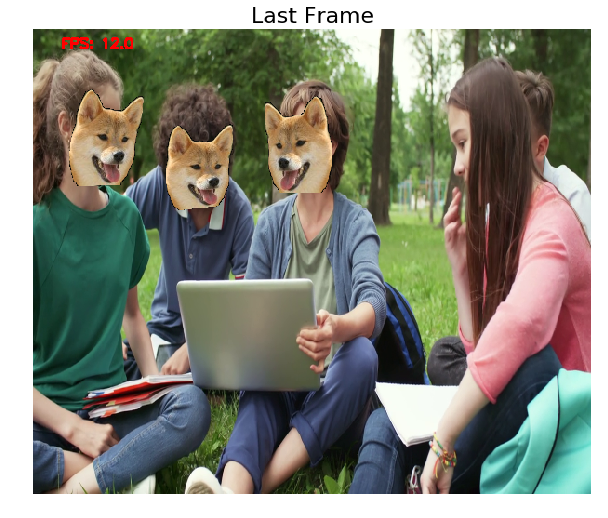

In [113]:
OpCV_Utils.show_single_img_plt(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), 'Last Frame', fig_size = (10,13))